## Carga de entorno y librerias

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_auc_score, 
                             roc_curve, f1_score, matthews_corrcoef, make_scorer)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.spatial.distance import cdist
import shap
import warnings

# Configuración Global
warnings.filterwarnings('ignore')
sns.set(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

print(" Librerías cargadas para SVM.")

 Librerías cargadas para SVM.


## Carga y estandarizacion de datos

In [5]:
# 1. Cargar datasets
train = pd.read_csv(r"C:\Users\benja\Desktop\QSAR\EDA/FINAL_Training.csv")
test = pd.read_csv(r"C:\Users\benja\Desktop\QSAR\EDA/FINAL_Test.csv")
ext = pd.read_csv(r"C:\Users\benja\Desktop\QSAR\EDA/FINAL_External.csv")

# 2. Definir Variables
target_col = 'Actividad'
features = [c for c in train.columns if c != target_col]

print(f"Variables ({len(features)}): {features}")

# 3. Codificación de Clase
le = LabelEncoder()
y_train = le.fit_transform(train[target_col])
y_test = le.transform(test[target_col])
y_ext = le.transform(ext[target_col])

# 4. Estandarización
# Ajustamos SOLO con train
scaler = StandardScaler()
X_train_np = scaler.fit_transform(train[features])
X_test_np = scaler.transform(test[features])
X_ext_np = scaler.transform(ext[features])

# Convertir a DataFrame
X_train = pd.DataFrame(X_train_np, columns=features)
X_test = pd.DataFrame(X_test_np, columns=features)
X_ext = pd.DataFrame(X_ext_np, columns=features)

print("Datos escalados correctamente.")

Variables (11): ['LOGPcons', 'MACCSFP125', 'PCR', 'Psi_e_A', 'P_VSA_ppp_D', 'Mp', 'SpMin1_Bh(p)', 'SHED_AL', 'SM12_AEA(ri)', 'P_VSA_s_3', 'MATS5m']
Datos escalados correctamente.


## Tuning

In [6]:
print(" Iniciando Tuning de SVM ")

param_grid = {
    'C': [0.1, 1, 10, 100],            # Regularización
    'gamma': ['scale', 'auto', 0.1, 1], # Coeficiente del kernel
    'kernel': ['rbf', 'linear'],       # Tipo de hiperplano
    'class_weight': ['balanced', None] # Manejo de desbalance
}

# Habilitamos probabilidad para curvas ROC
svc = SVC(probability=True, random_state=42)

grid_search = GridSearchCV(
    estimator=svc, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train, y_train)
best_svm = grid_search.best_estimator_

print(f" Mejores parámetros SVM: {grid_search.best_params_}")
print(f"Mejor AUC en CV: {grid_search.best_score_:.4f}")

 Iniciando Tuning de SVM 
Fitting 5 folds for each of 64 candidates, totalling 320 fits
 Mejores parámetros SVM: {'C': 0.1, 'class_weight': None, 'gamma': 0.1, 'kernel': 'rbf'}
Mejor AUC en CV: 0.7905


## Evaluacion de metricas

In [7]:
def calcular_metricas(model, X, y, nombre_set):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    
    return {
        'Dataset': nombre_set,
        'Accuracy': accuracy_score(y, y_pred),
        'Sensibilidad (TP Rate)': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'Especificidad (TN Rate)': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'AUC-ROC': roc_auc_score(y, y_prob),
        'Kappa': (2 * (tp * tn - fn * fp) / ((tp + fp) * (fp + tn) + (tp + fn) * (fn + tn))),
        'MCC': matthews_corrcoef(y, y_pred),
        'F1-Score': f1_score(y, y_pred)
    }

# Calcular métricas
res_train = calcular_metricas(best_svm, X_train, y_train, 'Training')
res_test = calcular_metricas(best_svm, X_test, y_test, 'Test Interno')
res_ext = calcular_metricas(best_svm, X_ext, y_ext, 'Validación Externa')

# Mostrar Tabla
df_res = pd.DataFrame([res_train, res_test, res_ext]).set_index('Dataset')
print(" RESULTADOS SVM:")
display(df_res.round(3))

 RESULTADOS SVM:


,Accuracy,Sensibilidad (TP Rate),Especificidad (TN Rate),AUC-ROC,Kappa,MCC,F1-Score
Dataset,,,,,,,
Training,0.751,0.827,0.664,0.821,0.495,0.500,0.781
Test Interno,0.737,0.834,0.625,0.807,0.464,0.472,0.772
Validación Externa,0.893,0.966,0.140,0.661,0.137,0.148,0.943


Estabilidad: Excelente control de overfitting. La diferencia mínima entre Train y Test (AUC 0.82 vs 0.80) demuestra que la regularización (C=0.1) funcionó perfectamente.
Sensibilidad: Extremadamente alta. En el set externo, el SVM supera incluso al Árbol de Decisión en detectar activos, comportándose como un filtro muy permeable
Especificidad: El punto débil. La especificidad cae drásticamente en validación externa. El modelo tiende a clasificar casi todo como "Activo" ante la duda.
MCC: El bajo coeficiente de Matthews en externo refleja que, aunque acierta mucho (High Accuracy), carece de la capacidad discriminante balanceada del Random Forest.

## Visualizacion

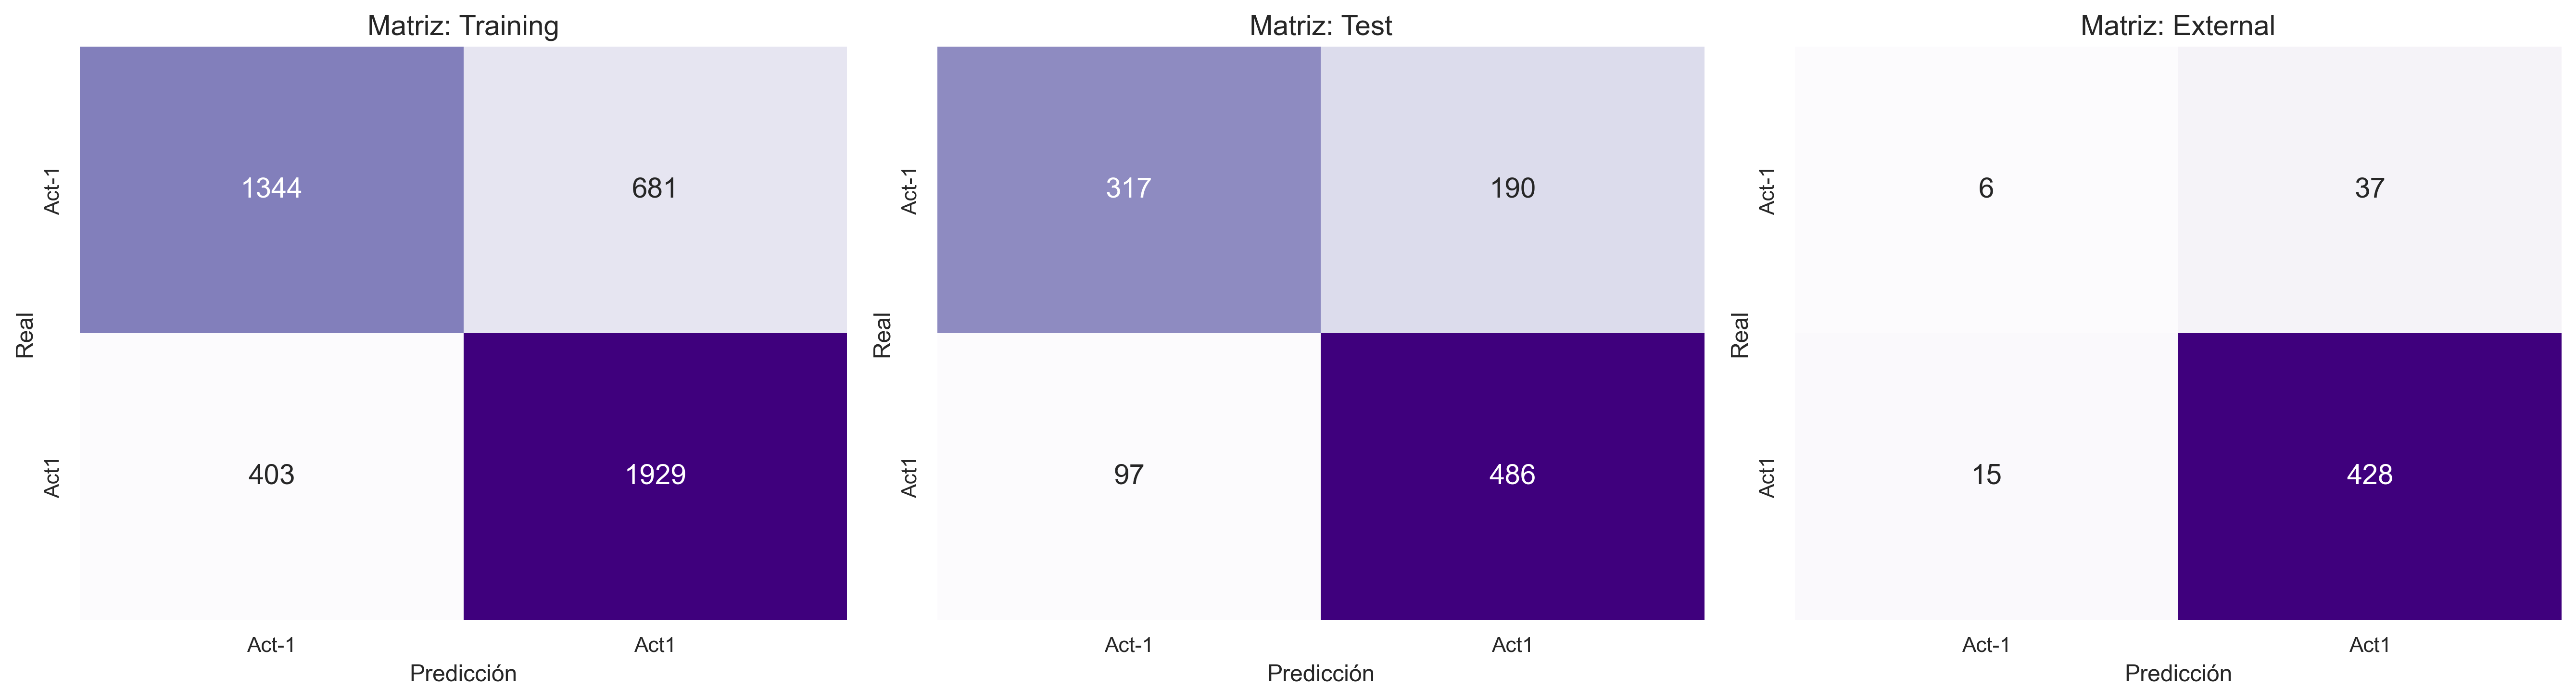

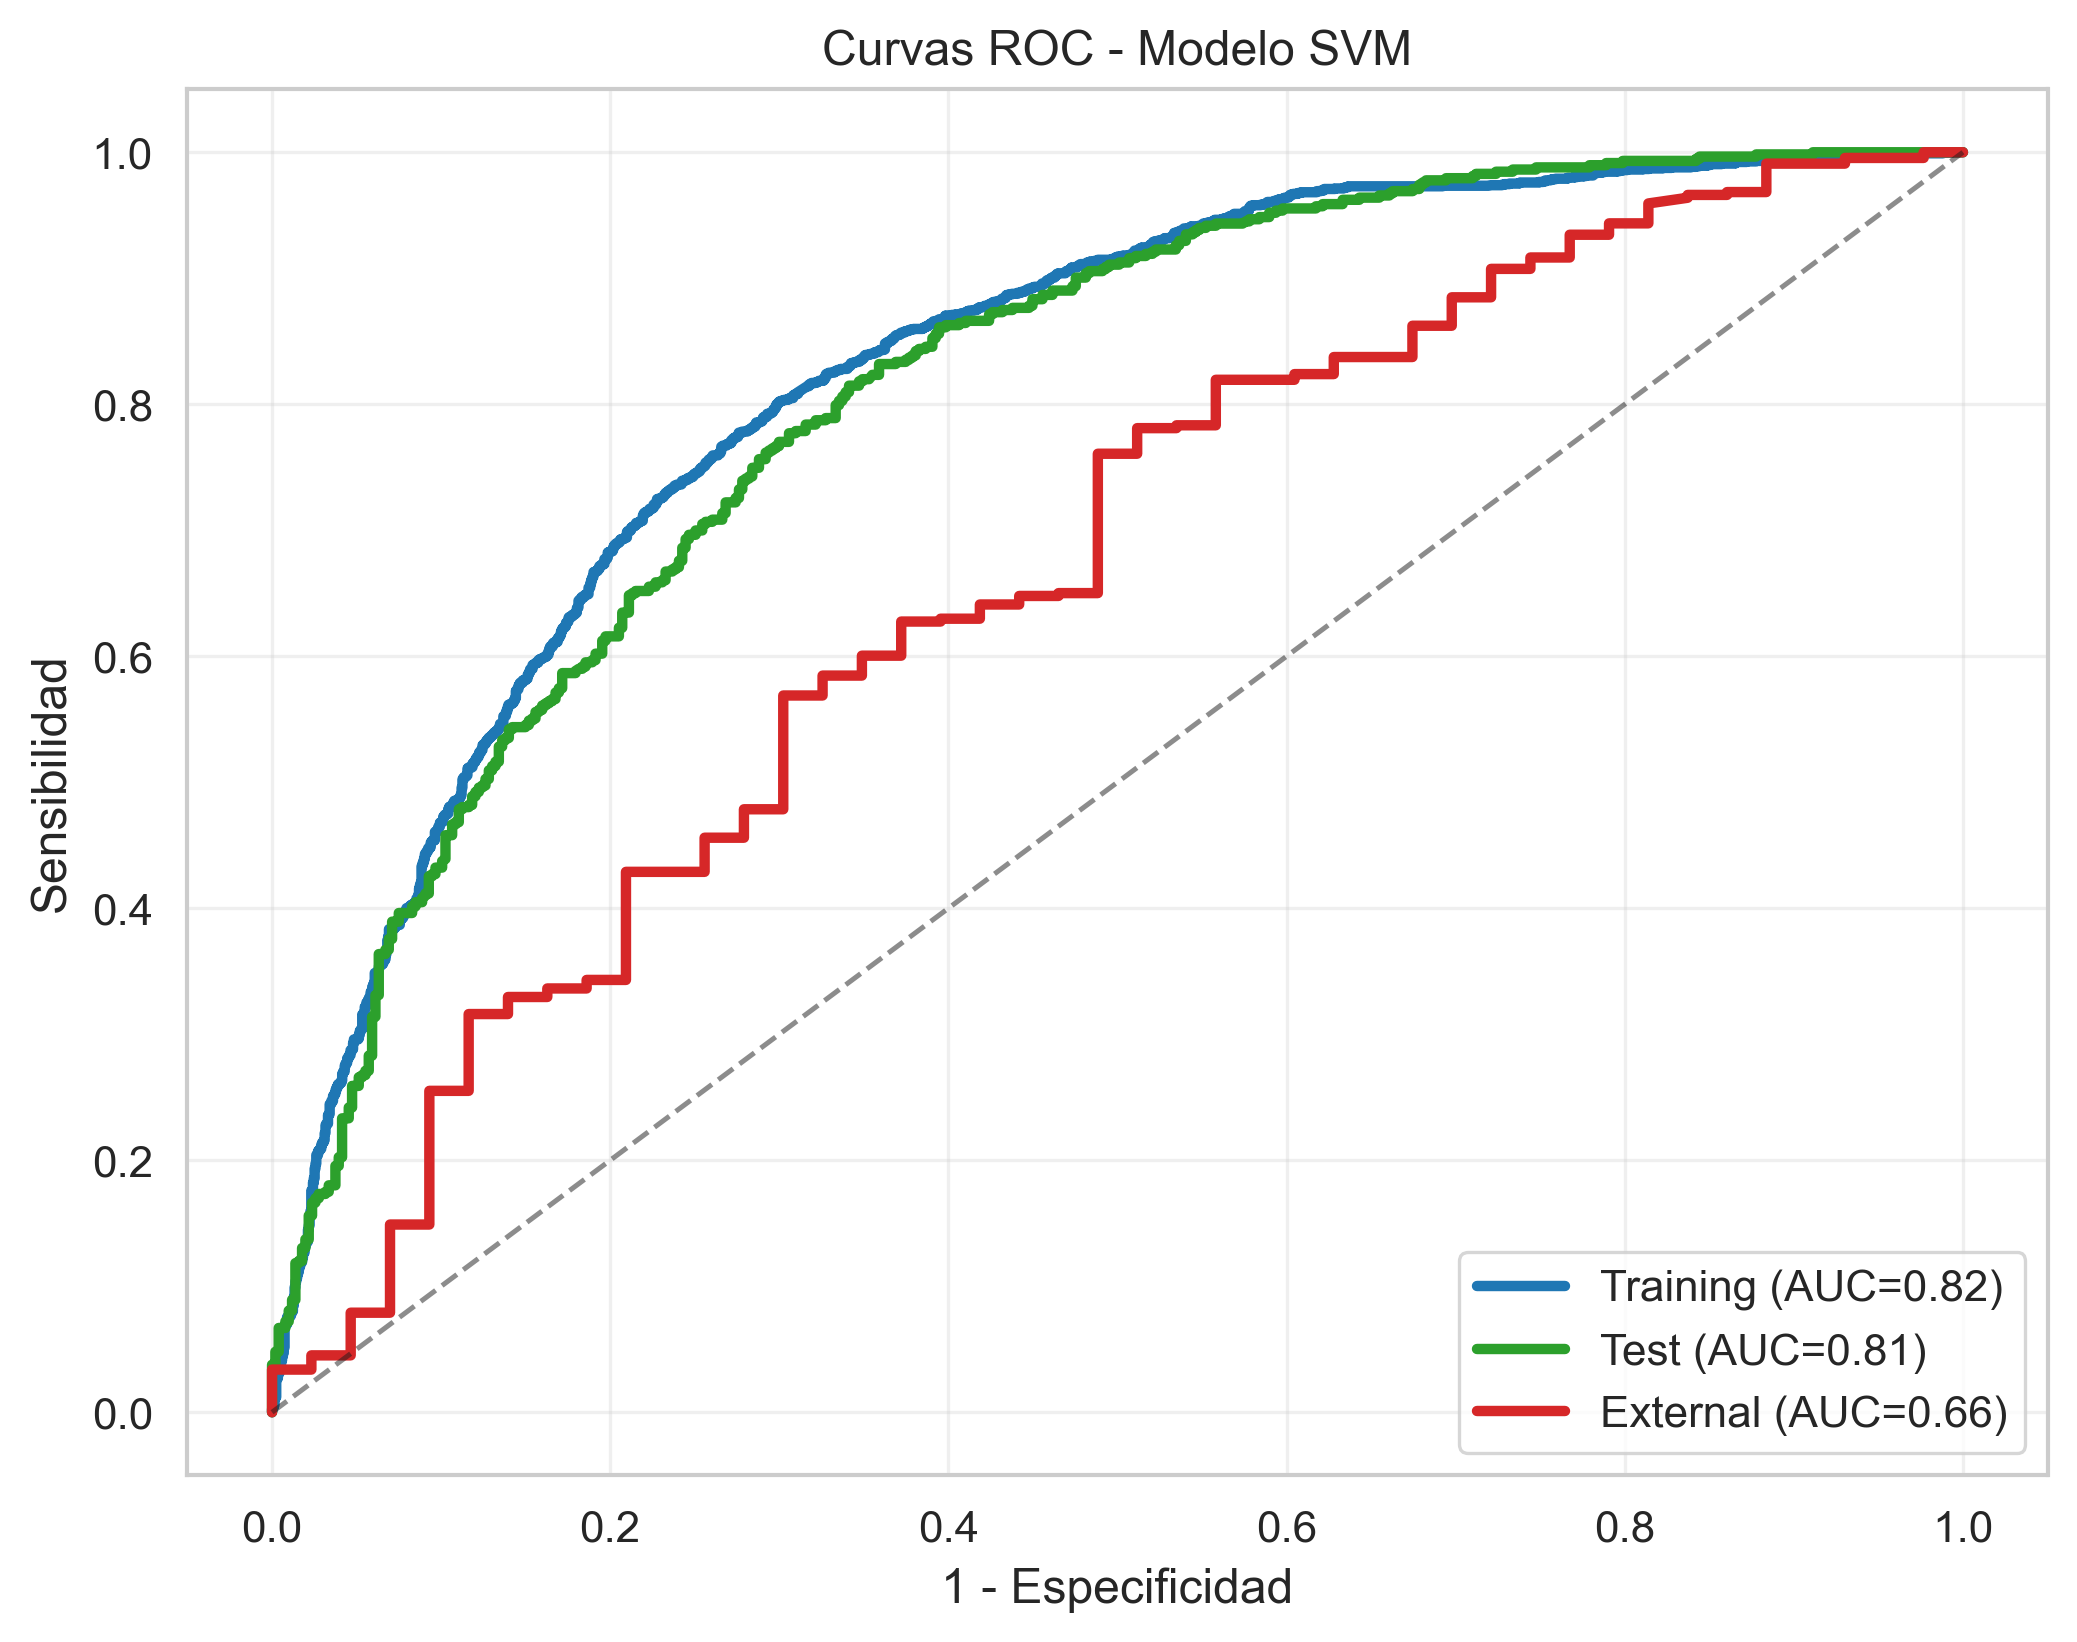

In [8]:
# A. MATRICES DE CONFUSIÓN
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sets = [(X_train, y_train, 'Training'), (X_test, y_test, 'Test'), (X_ext, y_ext, 'External')]

for i, (X_c, y_c, title) in enumerate(sets):
    cm = confusion_matrix(y_c, best_svm.predict(X_c))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=axes[i], cbar=False,
                xticklabels=le.classes_, yticklabels=le.classes_, annot_kws={"size": 14})
    axes[i].set_title(f'Matriz: {title}', fontsize=14)
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Real')

plt.tight_layout()
plt.show()

# B. CURVAS ROC
plt.figure(figsize=(8, 6))
colors = ['#1f77b4', '#2ca02c', '#d62728']

for (X_c, y_c, title), color in zip(sets, colors):
    y_prob = best_svm.predict_proba(X_c)[:, 1]
    fpr, tpr, _ = roc_curve(y_c, y_prob)
    auc = roc_auc_score(y_c, y_prob)
    plt.plot(fpr, tpr, label=f'{title} (AUC={auc:.2f})', color=color, lw=2.5)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('1 - Especificidad')
plt.ylabel('Sensibilidad')
plt.title('Curvas ROC - Modelo SVM')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

Test Interno: Muestra un equilibrio aceptable, logrando identificar correctamente una buena proporción de inactivos (True Negatives).

Validación Externa: El modelo colapsa hacia la clase mayoritaria.

TP (Verdaderos Positivos): Masivos. Casi no hay fugas de activos.

TN (Verdaderos Negativos): Muy bajos (14%). El SVM, al intentar maximizar el margen con un C bajo en un dataset desbalanceado, decidió que la estrategia más segura era predecir "Activo" para la gran mayoría de los compuestos desconocidos.

Las curvas de Training (Azul) y Test (Verde) están prácticamente superpuestas. Esto es la firma visual de un modelo que no ha memorizado los datos, validando la robustez matemática del SVM.

Sin embargo, la curva Externa (Roja), aunque se mantiene por encima del azar, muestra una caída más pronunciada en la tasa de falsos positivos iniciales en comparación con el Random Forest, lo que explica la baja especificidad.

## Interpretabilidad

 Calculando SHAP para SVM (Kernel Aproximado)...
Procesando 50 muestras...


  0%|          | 0/50 [00:00<?, ?it/s]

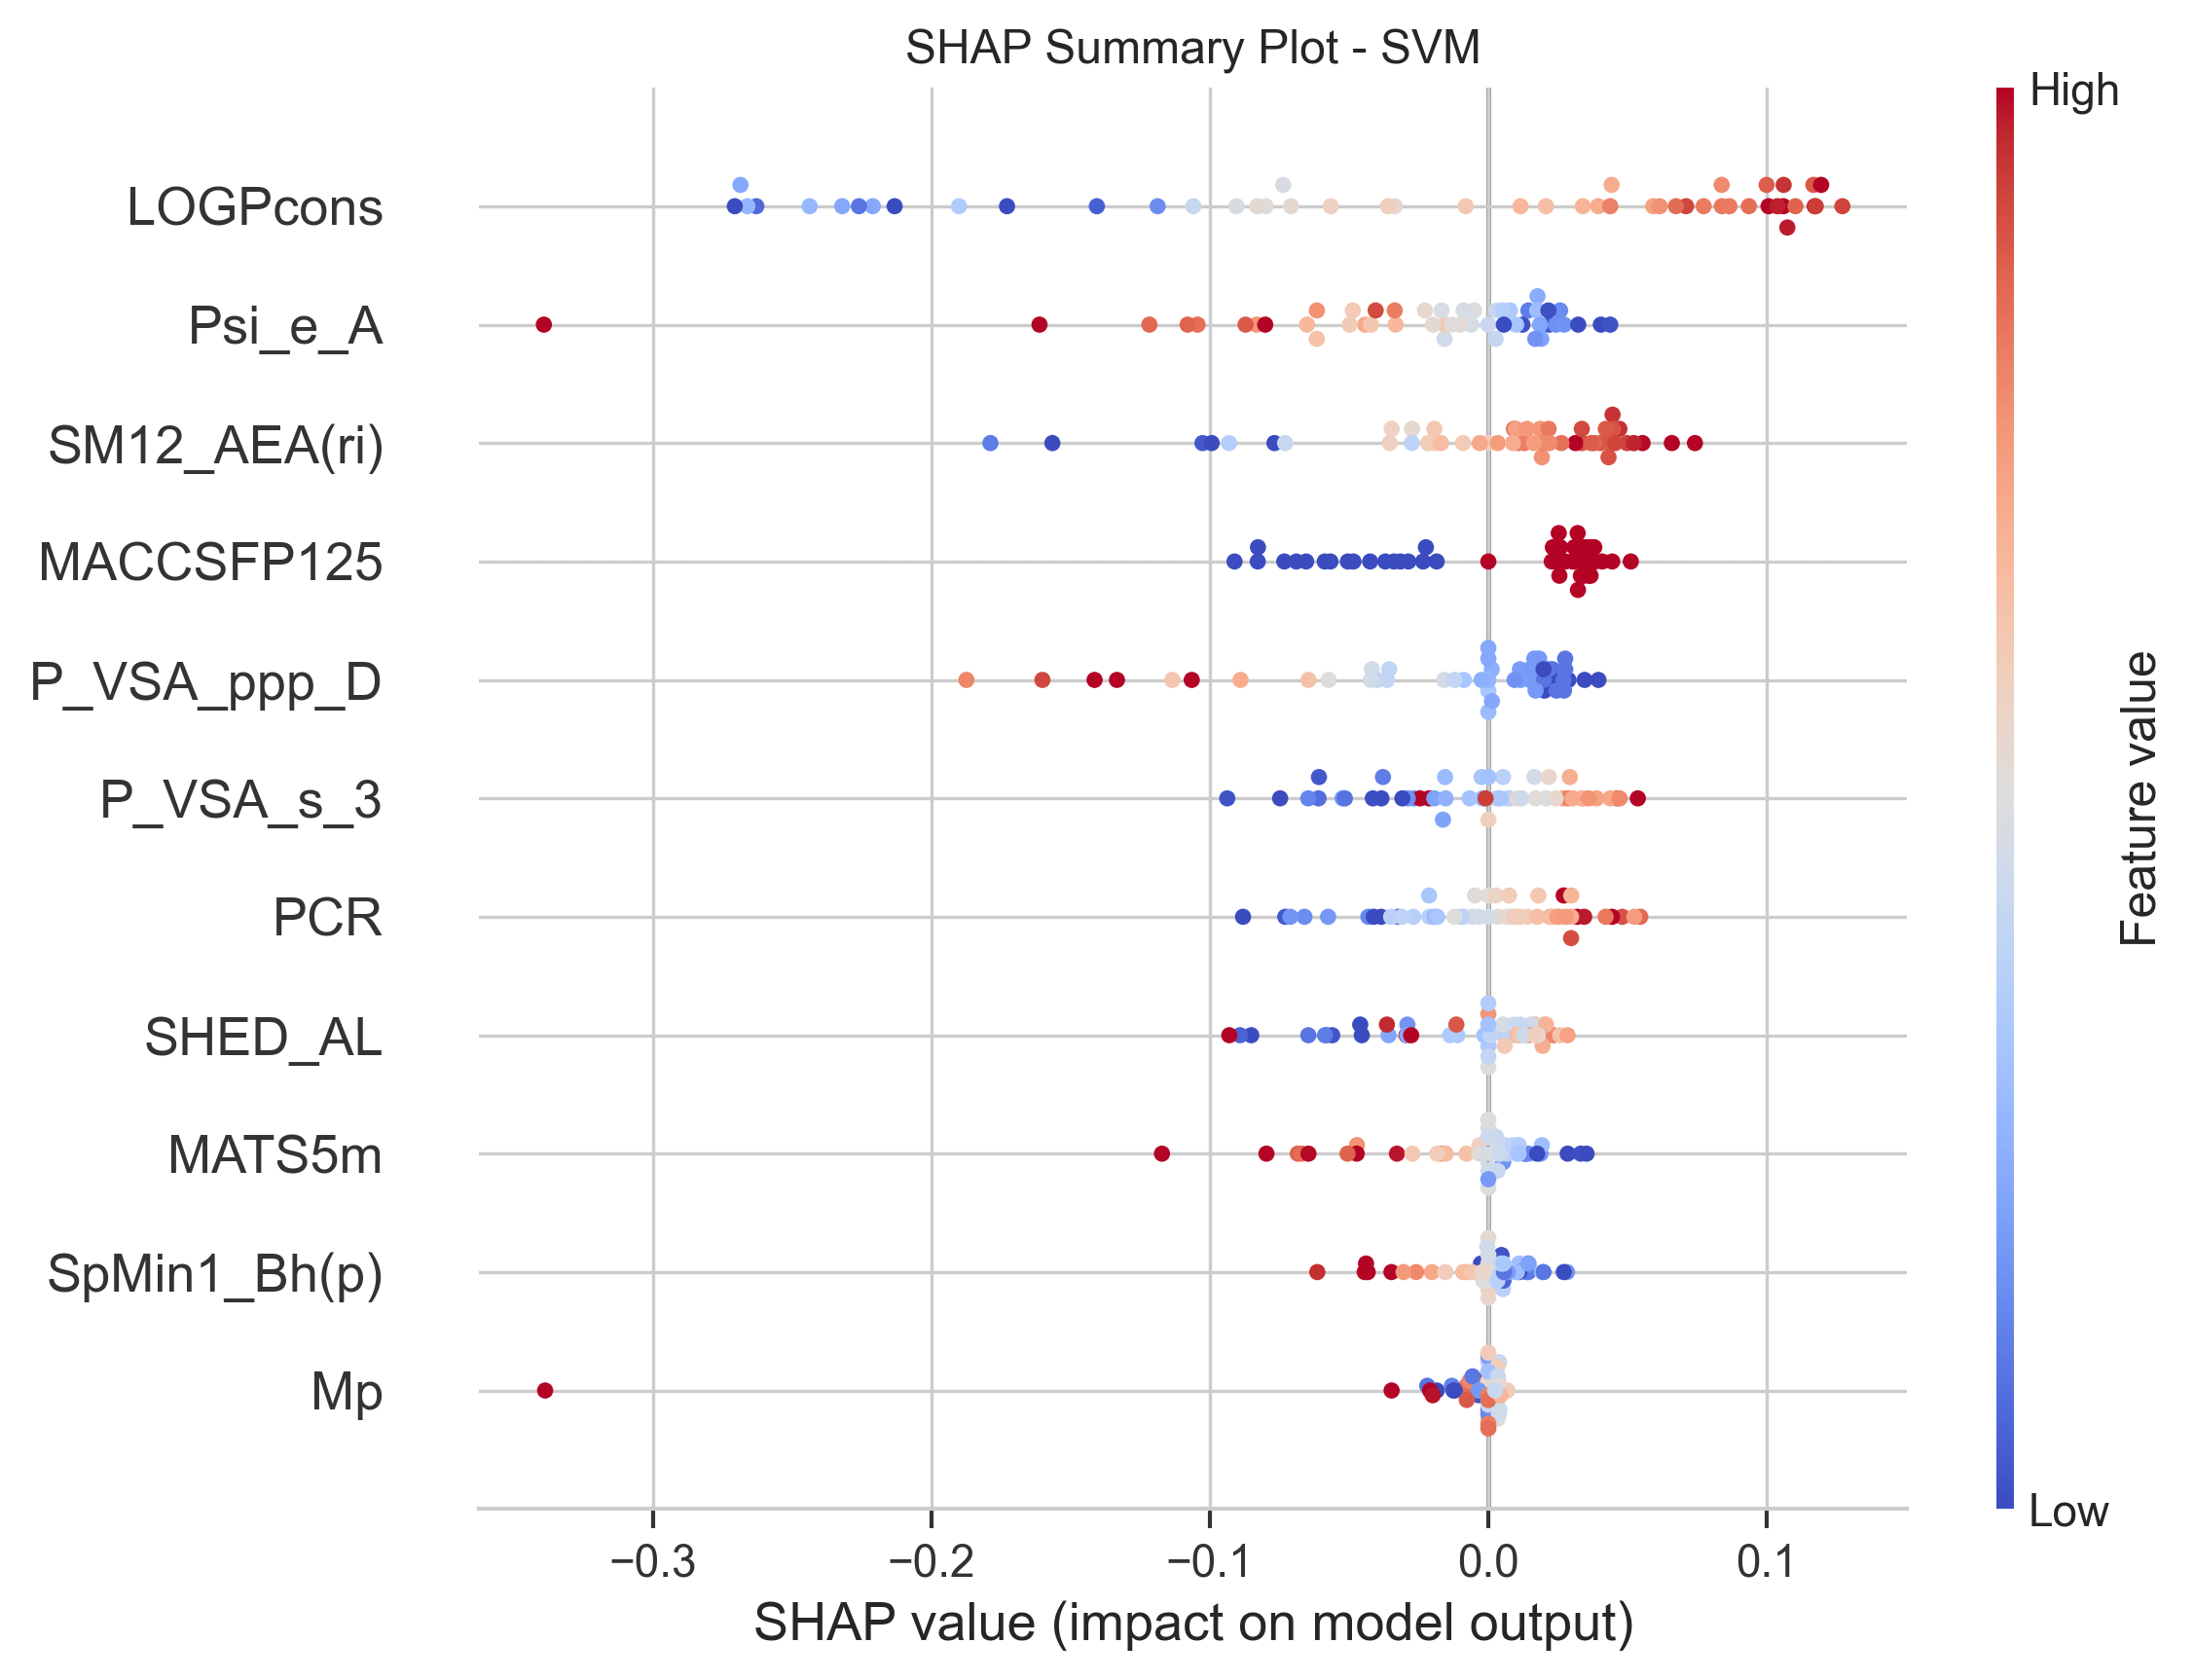

In [9]:
print(" Calculando SHAP para SVM (Kernel Aproximado)...")

# 1. Resumir Fondo (K-means)
# Usamos .values para asegurar array NumPy
X_train_summary = shap.kmeans(X_train.values, 10)
explainer = shap.KernelExplainer(best_svm.predict_proba, X_train_summary)

# 2. Muestra de Test
X_sample = X_test.sample(n=min(50, len(X_test)), random_state=42)
print(f"Procesando {len(X_sample)} muestras...")
shap_values = explainer.shap_values(X_sample)

# 3. Ajuste de dimensiones
vals_to_plot = None
if isinstance(shap_values, list):
    vals_to_plot = shap_values[1]
else:
    if len(shap_values.shape) == 3:
        vals_to_plot = shap_values[:, :, 1]
    else:
        vals_to_plot = shap_values

# Limpieza extra de columnas fantasmas
if vals_to_plot.shape[1] != X_sample.shape[1]:
    vals_to_plot = vals_to_plot[:, :X_sample.shape[1]]

plt.figure()
plt.title("SHAP Summary Plot - SVM")
shap.summary_plot(vals_to_plot, X_sample, show=False, cmap='coolwarm')
plt.show()

## Dominio de aplicabilidad

 Evaluando Dominio de Aplicabilidad...


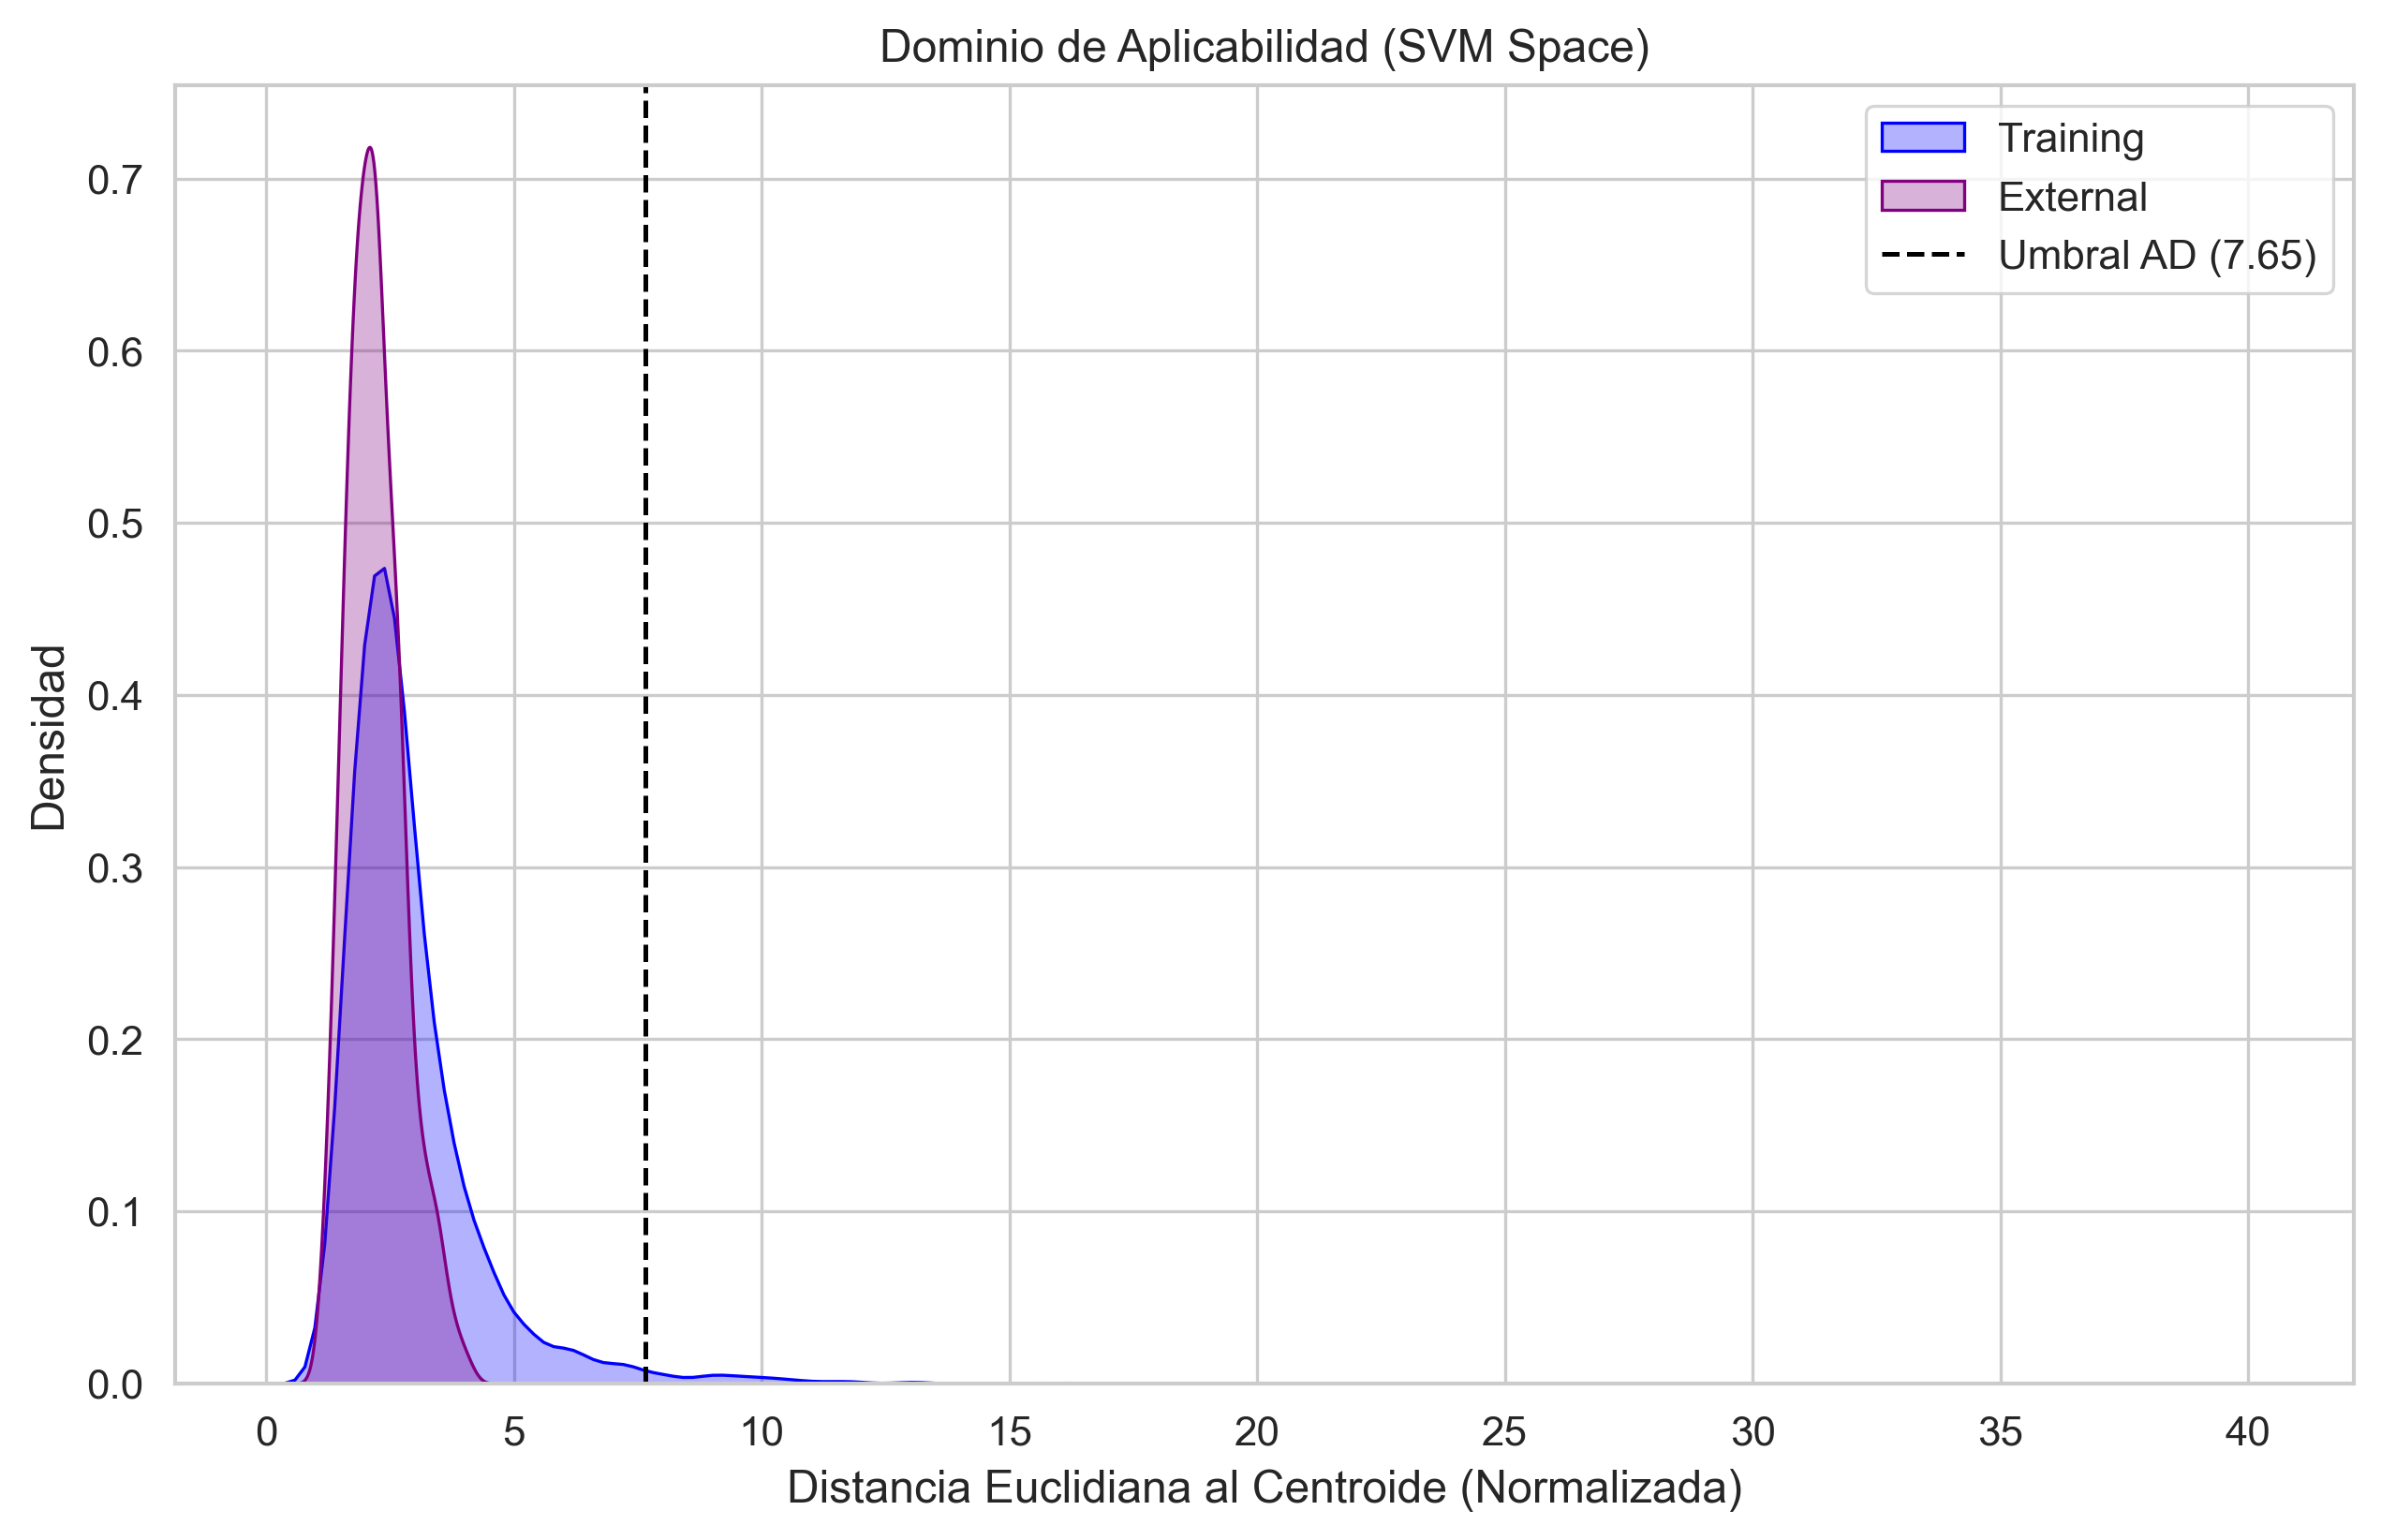

Compuestos externos fuera del dominio: 0 de 486 (0.0%)


In [10]:
print(" Evaluando Dominio de Aplicabilidad...")

# Centroide sobre datos estandarizados
# Usamos .values para evitar errores de Pandas/Numpy
centroid = X_train.mean(axis=0).values.reshape(1, -1)
dist_train = cdist(X_train.values, centroid, 'euclidean')
dist_ext = cdist(X_ext.values, centroid, 'euclidean')
limit_ad = np.mean(dist_train) + 3 * np.std(dist_train)

plt.figure(figsize=(10, 6))
sns.kdeplot(dist_train.flatten(), fill=True, color='blue', label='Training', alpha=0.3)
sns.kdeplot(dist_ext.flatten(), fill=True, color='purple', label='External', alpha=0.3)
plt.axvline(limit_ad, color='black', linestyle='--', label=f'Umbral AD ({limit_ad:.2f})')
plt.xlabel('Distancia Euclidiana al Centroide (Normalizada)')
plt.ylabel('Densidad')
plt.title('Dominio de Aplicabilidad (SVM Space)')
plt.legend()
plt.show()

n_out = np.sum(dist_ext > limit_ad)
print(f"Compuestos externos fuera del dominio: {n_out} de {len(dist_ext)} ({n_out/len(dist_ext)*100:.1f}%)")

El modelo SVM demostró ser una herramienta excepcionalmente robusta y estable, libre de sobreajuste. Su sensibilidad del 96.6% lo convierte en un filtro de seguridad válido. Sin embargo, su incapacidad para filtrar inactivos (Especificidad 14.0%) genera un exceso de Falsos Positivos, lo que lo hace menos eficiente que el Random Forest (Especificidad 23.3%) para reducir costos en etapas posteriores del descubrimiento de fármacos.